In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns
import textwrap
plt.rcParams['figure.figsize'] = (6,6)

### OCR

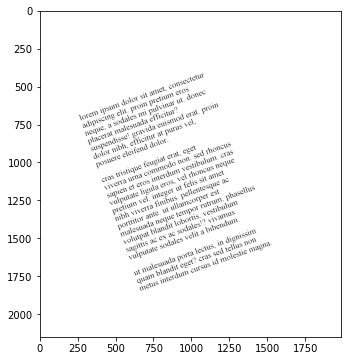

In [4]:
def read_file(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def display(*args, **kwargs):
    plt.figure(**kwargs)
    for i in range(len(args)):
        plt.subplot(1, len(args), i+1)
        imgplot = plt.imshow(args[i], cmap='Greys_r')
    plt.show()
    
img = read_file('imgs/lorem5.jpg')
display(img)

#### Denoise

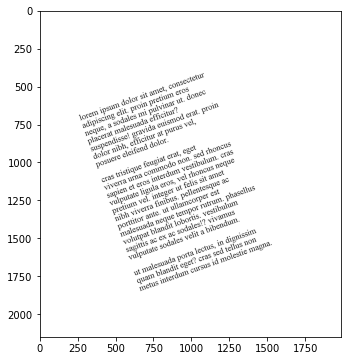

In [5]:
def denoise(img, sigma=3, blocksize=21, C=5):
    blurred = cv2.GaussianBlur(img, (sigma, sigma), 0)
    thresh = cv2.threshold(blurred, 0, 255,cv2.THRESH_TOZERO)[1]
    thresh = cv2.adaptiveThreshold(thresh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, C)
    return thresh

img = denoise(img, sigma=3)
display(img)

### Rotate and center

In [6]:
def sort_clockwise(pts, center=None):
    center = center or pts.mean(axis=0)
    return np.array(sorted(pts, key = lambda x:np.arctan2(x[0] - center[0], x[1]- center[1])))

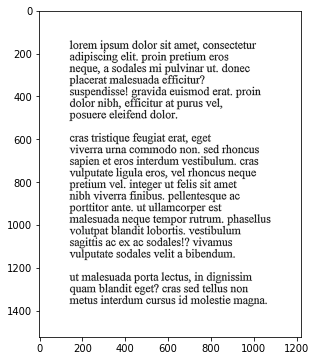

In [7]:
def get_text_block(img, sigma=41, pad=140):
    # detect block of text and focus on it
    blurred = cv2.GaussianBlur(img, (sigma, sigma), 0)
    thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU )[1]
    coords = np.column_stack(np.where(thresh == 0))
    (x,y), (w,h), angle = cv2.minAreaRect(coords)
    if angle<45:
        w,h = h,w
        angle+=90
    
    # warp
    dst = cv2.boxPoints(((x,y), (w+sigma,h+sigma), angle))[:,[1,0]]
    dst = sort_clockwise(dst)
    src = cv2.boxPoints(((w/2,h/2), (w+sigma,h+sigma), 0))
    src = sort_clockwise(src)
    M = cv2.getPerspectiveTransform(dst, src)
    img = cv2.warpPerspective(img, M, np.int32([w, h]))
    
    # threshold
    #img = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY)[1]
    img = denoise(img)
    
    # pad
    img = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(255,255,255))
    
    return img
    

img = get_text_block(img)
display(img)

#### Invert and normalize

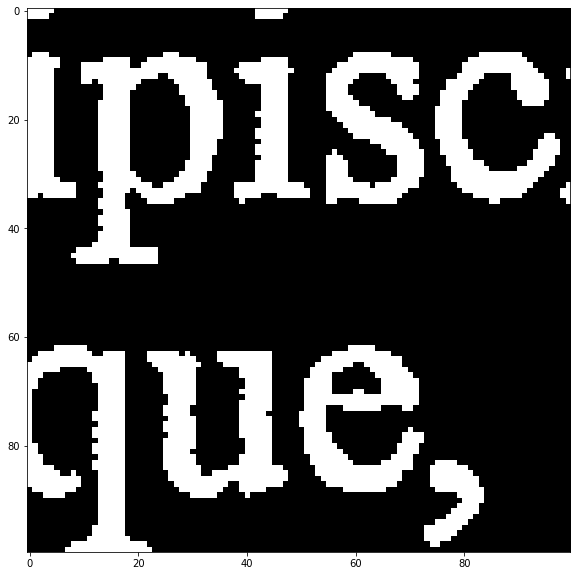

In [8]:
img = cv2.bitwise_not(img)/255
display(img[200:300,200:300], figsize=(10,10))

### Morphology

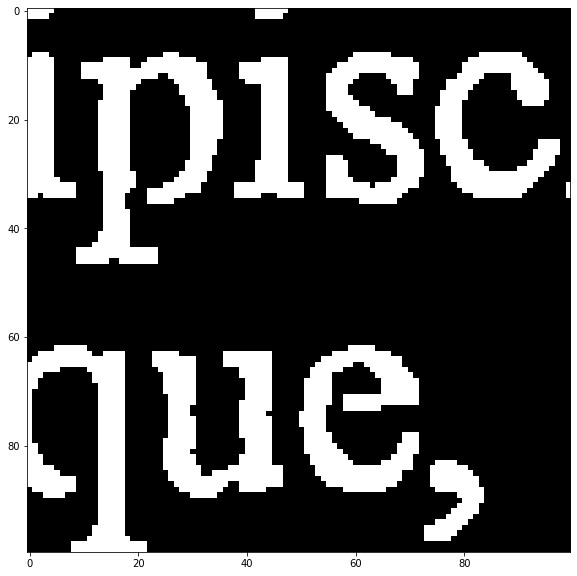

In [9]:
def smooth(img):
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((3,3)))
    return img

img = smooth(img)
display(img[200:300,200:300], figsize=(10,10))

### Detect lines and estimate char size

Char size:  54.0


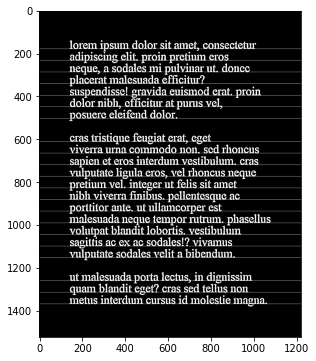

In [10]:
def get_lines(img, shift=2):
    y = img.mean(axis=1)
    y = np.minimum(1, 3*y/np.max(y))
    y = np.convolve(y, np.hanning(5), 'same')
    
    dif = y-np.roll(y, -1)
    peaks = (dif>np.roll(dif, -1)) * (dif>np.roll(dif, 1))
    threshold = dif>np.max(dif)/2
    
    lines = np.argwhere(threshold * peaks)
    
    spaces = lines[1:] - np.roll(lines, 1)[1:]
    valid_spaces = np.abs((spaces - spaces.mean())/(spaces.std()+0.1)<1)
    interline = spaces[valid_spaces].mean()
    
    return lines+shift, interline

lines, char_size = get_lines(img, shift=0)
print("Char size: ",  char_size)
img_lines = np.copy(img)
img_lines[lines, :] = 1
display(img_lines)

### Load chars

In [11]:
chars_arr = [chr(i) for i in range(97,123)]\
+ [chr(i) for i in range(48,58)]\
#+ ['?', '!', '.', ',']\
#+ [chr(i) for i in range(63,91)] 
 
print(chars_arr)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


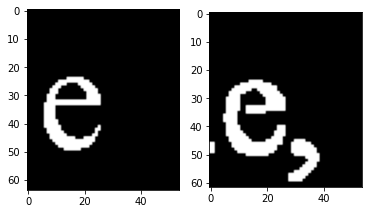

In [12]:
def load_chars(font_path, chars, size=44):
    font = ImageFont.truetype("fonts/times.ttf", size)
    result = []
    for char in chars:
        out = Image.new("P", (size, int(size*1.2)), 255)
        draw = ImageDraw.Draw(out)
        draw.text((4, 0), char, font=font)
        result.append(np.array(out))
        
    return cv2.bitwise_not(np.array(result))/255

chars = load_chars('font/times.ttf', chars_arr, size=round(char_size))
#chars = chars/chars.sum(axis=(1,2), keepdims=True)
display(chars[4], img[238:300,245:299])

### Char confusion

<AxesSubplot:>

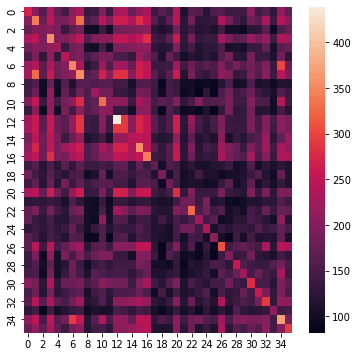

In [13]:
def get_confusion(chars):
    scores = np.zeros((len(chars), len(chars)))
    for i, char1 in enumerate(chars):
        bloadted_char = cv2.dilate(char1, np.ones((2,2), dtype=np.uint8))
        bloadted_char[bloadted_char>0] = 1
        fft_1 = np.fft.fft2(bloadted_char)
        for j, char2 in enumerate(chars):
            
            fft_2 = np.fft.fft2(np.rot90(char2, 2), s=fft_1.shape)
            corr = np.real(np.fft.ifft2(fft_1 * fft_2))
            scores[i,j] = np.max(corr)
    return scores

sns.heatmap(get_confusion(chars))

### Get char spans for later

In [14]:
def get_span(char):
    horizontal = char.sum(axis=0)>0
    start = np.argmax(horizontal)
    end = np.argmin(horizontal[start:]) + start
    return start, end+1

char_spans = [get_span(char) for char in chars]

### Adjust chars imgs

<AxesSubplot:>

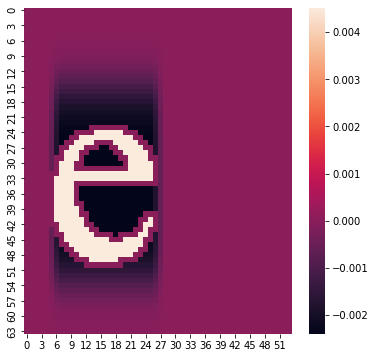

In [15]:
def adjust_char(char, char_span):
    
    outline = cv2.dilate(char, np.ones((3,3), dtype=np.uint8), iterations=1)
    
    bg = np.zeros(char.shape)
    bg[char.shape[0]//4:5*char.shape[0]//6, char_span[0]:char_span[1]] = 1
    bg = cv2.GaussianBlur(bg, (3, 1 + 2*(char.shape[1]//4)), 0)
    
    result = -bg
    result[outline>0] = 0
    result[char>0] = 1
    result[result>0] /= char.sum()
    result[result<0] /= -result[result<0].sum()
    
    return result

chars = np.array([adjust_char(char, span) for char, span in zip(chars, char_spans)])
sns.heatmap(chars[4])

### Correlate

<AxesSubplot:>

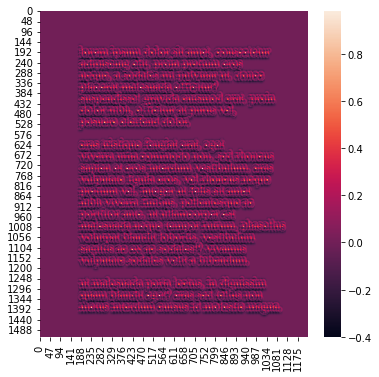

In [16]:
def get_correlations(img, chars):
    img_fft = np.fft.fft2(img)
    
    result = []
    for c in chars:
        c_fft = np.fft.fft2(np.rot90(c, 2), s=img_fft.shape)
        corr = np.real(np.fft.ifft2(img_fft * c_fft)) 
        result.append(corr)
    return np.array(result)

corrs = get_correlations(img, chars)
sns.heatmap(corrs[4])

### Adjust for predetected lines - linearize correlations

<AxesSubplot:>

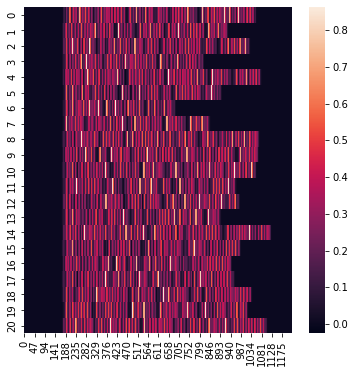

In [17]:
def transform_to_linear(corr_map, lines, line_window=np.ones(21)):
    linear_corrs = []
    for line in lines:
        linear_corr = corr_map[line+np.arange(len(line_window)), :]
        linear_corr *= line_window.reshape(-1,1)
        linear_corr = linear_corr.max(axis=0)
        linear_corr = np.convolve(linear_corr, np.ones(5), 'same')/5
        linear_corrs.append(linear_corr)

    return np.array(linear_corrs)

corrs = np.array([transform_to_linear(corr, lines) for corr in corrs])
sns.heatmap(corrs[4])

<AxesSubplot:>

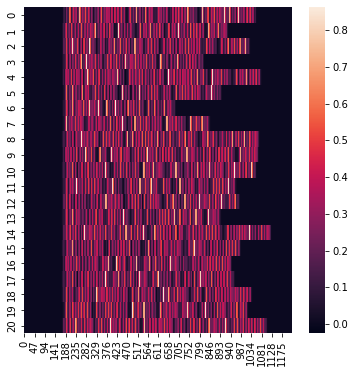

In [18]:
sns.heatmap(corrs[4])

### Get spaces

<AxesSubplot:>

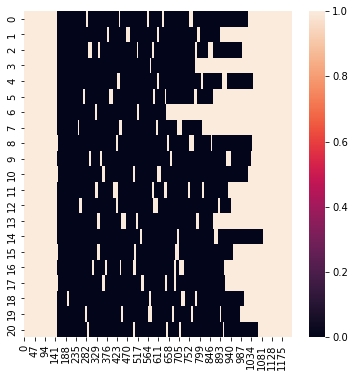

In [80]:
def get_spaces(img, char_size, lines):
    space = np.ones( (int(char_size//2), int(char_size//3)) )
    space /= space.sum()
    space_corr = get_correlations(img, [space])[0]
    space_corr = transform_to_linear(space_corr, lines)
    for i in range(len(space_corr)):
        space_corr[i] = np.convolve(space_corr[i], np.ones(int(char_size//3)), 'same')/int(char_size//3)
    return space_corr<0.2
spaces = get_spaces(img, char_size, lines)
sns.heatmap(spaces)

### Pick most promising detections

<AxesSubplot:>

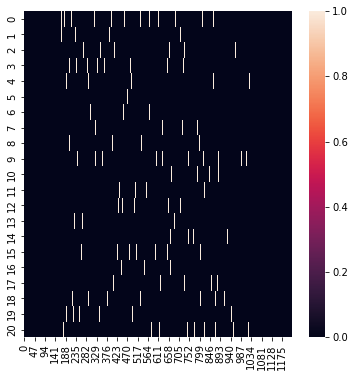

In [101]:
def pick_detections(corrs, char_spans, spaces):
    occupied = np.copy(spaces).astype(np.int32)
    picks = np.copy(spaces).astype(np.int32)
    mean = corrs.mean()
    
    for i in range(corrs.shape[1]):
        line = corrs[:,i,:]
        
        best_scores = np.max(line, axis=0)
        best_chars = np.argmax(line, axis=0)
        best_spots = np.argsort(-best_scores)
        
        for spot in best_spots:
            score = best_scores[spot]
            char = best_chars[spot]
            if score<mean:
                break
            start, end = char_spans[char]
            if not np.any(occupied[i, spot+start-end:spot]>0):
                picks[i,spot+start-end] = char+2
                occupied[i, spot+start-end+2:spot-2] = 2
            
    return picks

detections = pick_detections(corrs, char_spans, spaces)
sns.heatmap(detections>1)

### Convert to text :(

In [99]:
def get_text(detections):
    char_arr_new = [' '] + chars_arr
    output = ''
    for line in detections:
        chars = [char_arr_new[x] for x in line[line>0].astype(np.int32)-1]
        output += ' '.join(''.join(chars).split()) + '\n'
        
    return output
text = get_text(detections)
print(text)

1orer iixs1n ido1o us1 rane jconisec1eu
adlpiiscni rel p1oi ipretun e1o
nequi 4 isoda1e rn ipuiviia u donc
pilscerutna1esaadl reftcius
sasoeadliss grv1dl ienisno lera p1oi
do1o niil1 jcf11ciu sa tpura ve
posaer ie1eieas ldo1o
cia rtristqui ifeag1a te1a jege
vveriau1ni iconinodl ino1 usc lrlonca
sap1e ie te1oi riue1dun vestiluiun crs
vuipuiat dlguil ie1oi velrlonc1i rnequi
pretur ve 4niege u 1eli rs tane
niil vicerr ifniilui peleuesrui ia
porttio raut u uilancorce ses
nia1esaadanequi r1enpo ora1rm phasell1
voiuipa blndl s1oborti vestiluiun
sagitti ra ie ra isoda1es vicanu
vuipuiat rsoda1e vel t biileadun
u tnia1esaadaport i1ecui 0i idlgniissii
quar bilndl tege1 crs rse l1elu rno
aneu rnierun icarsa ri lno1esti rniagni



### Compare to the real text :(

In [100]:
def text_format(text, chars_per_line):
    text = text.lower()
    text_to_draw = ''
    for par in text.split('\n'):
        par = textwrap.wrap(par, width=chars_per_line)
        par = '\n'.join(par)
        text_to_draw += par + '\n\n'
    return text_to_draw

with open('lorem.txt', 'r') as f:
    real_text = f.read()
print(text_format(real_text, 40))

lorem ipsum dolor sit amet, consectetur
adipiscing elit. proin pretium eros
neque, a sodales mi pulvinar ut. donec
placerat malesuada efficitur?
suspendisse! gravida euismod erat. proin
dolor nibh, efficitur at purus vel,
posuere eleifend dolor.

cras tristique feugiat erat, eget
viverra urna commodo non. sed rhoncus
sapien et eros interdum vestibulum. cras
vulputate ligula eros, vel rhoncus neque
pretium vel. integer ut felis sit amet
nibh viverra finibus. pellentesque ac
porttitor ante. ut ullamcorper est
malesuada neque tempor rutrum. phasellus
volutpat blandit lobortis. vestibulum
sagittis ac ex ac sodales!? vivamus
vulputate sodales velit a bibendum.

ut malesuada porta lectus, in dignissim
quam blandit eget? cras sed tellus non
metus interdum cursus id molestie magna.




### Count letters

In [95]:
def count_letters(text):
    counter = {char: 0 for char in chars_arr}
    for letter in text:
        if letter in counter:
            counter[letter] += 1
            
    return counter

for (k, v), vr in zip(count_letters(text).items(), count_letters(real_text).values()):
    print(k, "   ", v, "/", vr, sep="")

a   49/51
b   4/10
c   21/16
d   20/24
e   64/78
f   3/8
g   9/9
h   1/5
i   89/52
j   3/0
k   0/0
l   35/38
m   1/27
n   43/33
o   35/35
p   18/17
q   5/6
r   46/45
s   41/51
t   24/55
u   40/51
v   15/15
w   0/0
x   1/1
y   0/0
z   0/0
0   3/0
1   41/0
2   0/0
3   1/0
4   1/0
5   0/0
6   0/0
7   0/0
8   0/0
9   0/0
